“What I cannot create, I do not understand.”

—Richard Feynman


Thanks to high powered graphics cards and neural networks, image classification is now more or less a solved problem.  But many machine learning enthusiasts don't really understand what's going on under the hood.  I decided to create this tutorial on how to code a complete image classification neural network from scratch, because until you can take something apart and put it back together again, you don't truly understand it.

While the below steps could technically done with no imports, numpy will make things a lot easier.  Neural networks are only fast when they make use of c-like arrays, which python does not have natively.

In [326]:
import numpy as np

Ok, so what is a neural network?  At its core, it's an acyclic directed graph of neurons, and those neurons are simply nonlinear regression functions.  The equation for a line is:

y = mx + b 

When talking about neural nets, we call the slope weights and the y-intercept bias, so it becomes:

y = wx + b

but this equation assumes that w and x are scalars.  If they're vectors, we want to multiply each weight times each x value and then add them together.  This is called the dot product, represented as

w⋅x


in order to turn this into nonlinear regression, we need to introduce nonlinearity with an activation function.  A popular one in neural networks is the sigmoid function, so we'll use that:

y = sigmoid(w⋅x + b)

The sigmoid function is defined like this

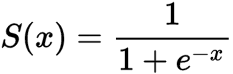

so let's put this into code, since we know we'll need it.  

In [327]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

  #Another perk of using numpy is that it has a built in function for raising euler's number to a power

We're also going to need a loss function to determine how badly to punish wrong answers.  A common one used is Mean Squared error

In [328]:
def MSE_loss(real, predicted):
    return 0.5*(real - predicted)**2

Now let's make our neuron class.  In my first attempt at this, I initially had a structure like this

<br>

neural network 

contains layers

contains neurons

contains **weights** and a **bias**

<br>

If you do it this way, the weights are a vector, the input is a vector, and the bias is a scalar.  However, I quickly realized why pytorch and tensorflow don't do it this way.  It's faster and cleaner to use a structure like this:

<br>

neural network

contains layers

contains a **weight matrix** of shape (number_of_neurons, number_of_weights) and a **bias vector** of length (number_of_neurons)


Essentially all we've done is just pack the neurons together.

If we do it this way, we can multiply a matrix of neurons times a vector of inputs and parallelize our forward and backward pass.  Essentially every neuron can get calculated at the same time using a GPU rather than one at a time with a CPU.

Before, each neuron had a vector of weights and a scalar bias.

Now, each layer will have a matrix of weight vectors and a vector of biases.

Since neurons are now just rows in a matrix, we don't need a neuron class, so let's define our Layer class that will contain all the neurons:

In [329]:
class Layer:
    def __init__(self,num_neurons, input_length):
        # this is the number of neurons in this layer
        self.num_neurons = num_neurons
        # this is the number of scalar values in the input vector
        self.input_length = input_length
        
        # note that weights and biases are initialized as random values and will become the right values after backpropagation

        
        # each neuron has as many weighs as there are input values
        # so the vector of weights is now a matrix of all the neuron weights in the layer
        self.weights = 2.0 * np.random.rand(num_neurons, input_length) - 1.0
        # there is always one bias per neuron, so biases will be a vector of length num_neurons
        self.biases = 2.0 * np.random.rand(num_neurons) - 1.0

    # the forward function will pass an input vector to every neuron
    # then it calculates every neuron's output at once and outputs them as a vector
    def forward(self,x):
        return sigmoid(np.dot(self.weights, x) + self.biases)

Now let's define our neural network class.  All it needs to do in the forward pass is feed the input into the first layer, and then feed each layer's output into the next layer.  For this example we'll define our network as having 3 hidden layer neurons and one output neuron for simplicity.

In [330]:
class NeuralNetwork:
    def __init__(self,input_length):

        # the hidden layer is composed of three neurons
        # each neuron will have as many weights as there are values in the input
        self.hidden_layer = Layer(3 ,input_length)
        # The outpupt layer will have a single neuron
        # it will have three weights, each one corresponding to the outputs of the three previous layer's neurons 
        self.output_layer = Layer(1,3)

        # this learning rate hyperparameter will be important when we implement backpropagation
        self.lr = 1
        
        # Putting the layers in a list lets us loop through them, while having them as variables still lets us hard-code things
        self.layers = [
                self.hidden_layer,
                self.output_layer
            ]

    # this function will pass the input through all the layers of neurons
    def forward(self,x):
        # we'll need to store every layer's output because these values are used to teach each layer what it did wrong in backpropagation
        output_vectors = []
        
        # loop through all of the layers, starting with the hidden layer
        for layer in self.layers:
            # check if we're on the first layer by checking if output_vectors is still empty
            if not output_vectors:
                # pass the first layer the input vector
                output = layer.forward(x)
            else:
                # otherwise, if it's not the first layer, pass it the previous layer's output, which will be the last value in output_vectors
                output = layer.forward(output_vectors[-1])
            # add the result of this layer's forward pass to the list of outputs
            output_vectors.append(output)
        # return these outputs for use in prediction and backpropagation
        return output_vectors

Now, believe it or not, we've actually built a neural network.  It's incapable of learning, because we haven't implemented backpropagation yet, but let's pass something through it and see what happens.

When I first started this project I wanted to get right to image classification, but before we get to that we should start with a toy example.  The XOR problem is the simplest way to check whether a neural network is capable of solving nonlinearly seperable problems is with the following dataset:

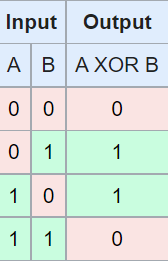



In [331]:
# this is the above data, expressed as a list of tuples in the form (input vector of length 2, correct class label)
xor_data = [([0, 0], 0), ([0, 1], 1), ([1, 0], 1), ([1, 1], 0)]

# create a neural network instance with an input length of 2 for the 3 hidden layer neurons
nn = NeuralNetwork(2)

# iterate through each input and class label in the data
for input_vector, class_label in xor_data:
  
  # pass the input vector to the neural net and collect the output
  output_vectors = nn.forward(input_vector)

  # the output of the last layer is the neural network's prediction
  prediction = output_vectors[-1]

  # calculate the loss
  loss = MSE_loss(class_label, prediction)
  print(f"input vector: {input_vector}     Correct class label: {class_label}     neural network predicted class label: {prediction}     loss: {loss}")
  


input vector: [0, 0]     Correct class label: 0     neural network predicted class label: [0.70491526]     loss: [0.24845276]
input vector: [0, 1]     Correct class label: 1     neural network predicted class label: [0.69251561]     loss: [0.04727333]
input vector: [1, 0]     Correct class label: 1     neural network predicted class label: [0.68950269]     loss: [0.04820429]
input vector: [1, 1]     Correct class label: 0     neural network predicted class label: [0.68072358]     loss: [0.2316923]


Because the weights and biases were initialized randomly and we haven't trained it at all, the outputs should be more or less random as well.  Try runninig the above cell multiple times to see this demonstrated.

Now it's time for the hardest part.  Let's implement backpropagation.  The first thing we want to find is how much the loss changes when we change the weights and biases.  This is called the delta, and it's found by taking the derivative of the loss with respect to the weights.

If our function looks like this, where z is the dot product of the weights and the inputs plus the bias, and σ is the sigmoid function:

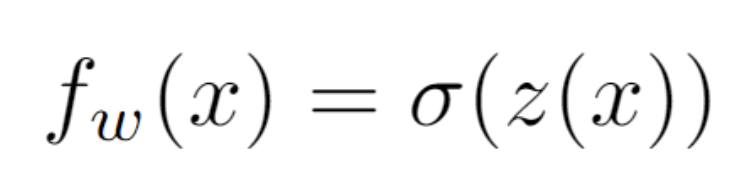

and our loss function is mean squared error, then the derivative of the loss with respect to the weights is calculated as follows, using chain rule to multiply the derivatives of the nested functions:

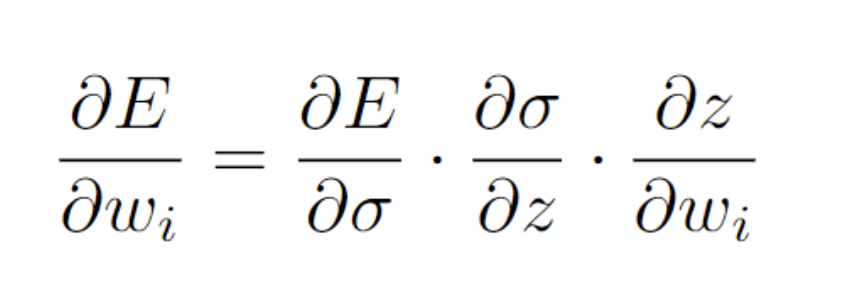

In words, this is

<br>

Derivative of error w.r.t weights = 

<br>


( derivative of error w.r.t sigmoid *

 derivative of sigmoid w.r.t. (the dot product + bias) * 
 
 derivative of (the dot product + bais) w.r.t. weights )

Taking each derivative individually:

<br>

dE/dsigmoid = <font color='firebrick'>output - ground_truth<font>

dsigmoid/dz = <font color='blue'>output * (1 - output)<font>

dz/dw = <font color='green'>input



This gives us the formula to calculate the delta for the output neuron:
<br>

output_delta = <font color='firebrick'>(output - ground_truth)<font> * <font color='blue'>output<font> *(1 - output) * <font color='green'>input<font>

but what about all the other neurons?

The derivative of the hidden layer depends on the derivative of the output layer, so we can't just calculate it the same way.  Instead let's think about it like a nested function, and then use chain rule to get:



Given neuron 1  -> neuron 2  -> neuron 3

				Neuron 3 delta =           dE/dw3
		  Neuron 2 delta = dE/dw2 =        d3w/d2w * dE/dw3
    Neuron 1 delta = dE/dw1 =		      d2w/d1w * d3w/d2w * dE/dw3

In other words, each delta uses the same formula as above, but because of chain rule we multiply it times the gradients of every layer that comes after it.  Implementing backpropagation means writing an algorithm to iteratively calculate these derivatives before using them to add and subtract from the weights.

note also that the derivative of the error with respect to the bias will be slightly different.  We calculated the weights using the derivative of the dot product plus the bias with respect to the weights, like this:

<br>

dz/dw = input

<br>

But for the bias we need the derivative of the dot product plus the bias with respect to the bias.  Since the derivative of a constant is 1, we get:

<br>

dz/db = 1

<br>

this means that instead of this formula

output_weight_delta = <font color='firebrick'>(output - ground_truth)<font> * <font color='blue'>output<font> *(1 - output) * <font color='green'>input<font>

<br>

we get this one:

output_bias_delta = <font color='firebrick'>(output - ground_truth)<font> * <font color='blue'>output<font> *(1 - output) * <font color='green'>1<font>

Ok, now that all the math is out of the way, we're ready to put it into code:
(the below code is just for demonstration, it won't do anything until we put it into the neural network class)

In [332]:
def backpropagate(self, output, y):

    # this is the dError/dSigmoid
    E1 = output[2] - y
    # this is the output bias delta, used to update the output neuron bias
    dW2 = E1 * output[2] * (1-output[2])

    # this is dweights_hidden/dweights_output
    E2 = np.dot(np.reshape(dW2, (1,1)), self.output_layer.weights)
    # this is hidden layer bias delta, used to update the hidden layer neuron biases
    dW1 = E2 * output[1] * (1-output[1])

    # now we multiply times the input to get the weights deltas

    # this is the output weights delta, used to update the output neuron weights
    W2_update = np.dot(np.reshape(output[1], (3,1)), np.reshape(dW2, (1,1)))
    # this is the hidden weights delta, used to update the hidden layer neuron weights
    W1_update = np.dot(np.reshape(output[0], (2,1)), dW1)

    # new biases = old biases - (learning rate * bias delta)
    self.output_layer.biases = self.output_layer.biases - self.lr * dW2
    self.output_layer.weights = self.output_layer.weights - self.lr * W2_update.T

    # new weights = old weights - (learning rate * weights delta)
    self.hidden_layer.biases = self.output_layer.biases - self.lr * np.reshape(dW1,(3,))
    self.hidden_layer.weights = self.hidden_layer.weights - self.lr * W1_update.T

Let's put our code all together and see how it does on the xor problem!

In [333]:
import numpy as np
def sigmoid(z):
    return 1/(1+np.exp(-z))

def derivative_of_sigmoid(z):
    return np.exp(z)/((np.exp(z) + 1)**2)

def L2_loss(real, predicted):
    return 0.5*(real - predicted)**2

class Layer:
    def __init__(self,num_neurons, input_length):
        self.num_neurons = num_neurons
        self.input_length = input_length
        self.weights = 2.0 * np.random.rand(num_neurons, input_length) - 1.0
        self.biases = 2.0 * np.random.rand(num_neurons) - 1.0
    def forward(self,x):
        return sigmoid(np.dot(self.weights, x) + self.biases)

class NeuralNetwork:
    def __init__(self,input_length, num_hidden_layer_neurons = 3):
        self.input_length = input_length
        self.hidden_layer = Layer(num_hidden_layer_neurons,self.input_length)
        self.output_layer = Layer(1,num_hidden_layer_neurons)
        self.lr = 1
        self.layers = [
                self.hidden_layer,
                self.output_layer
            ]
    def forward(self,x):
        output_vectors = []
        for layer in self.layers:
            if not output_vectors:
                output = layer.forward(x)
            else:
                output = layer.forward(output_vectors[-1])
            output_vectors.append(output)
        return output_vectors

    def backpropagate(self, output, y):
        E1 = output[2] - y
        dW2 = E1 * output[2] * (1-output[2])
        E2 = np.dot(np.reshape(dW2, (1,1)), self.output_layer.weights)
        dW1 = E2 * output[1] * (1-output[1])
        W2_update = np.dot(np.reshape(output[1], (self.hidden_layer.num_neurons,1)), np.reshape(dW2, (1,1)))
        W1_update = np.dot(np.reshape(output[0], (self.input_length,1)), dW1)

        self.output_layer.biases = self.output_layer.biases - self.lr * dW2
        self.output_layer.weights = self.output_layer.weights - self.lr * W2_update.T

        self.hidden_layer.biases = self.output_layer.biases - self.lr * np.reshape(dW1,(self.hidden_layer.num_neurons,))
        self.hidden_layer.weights = self.hidden_layer.weights - self.lr * W1_update.T

In [334]:
input_length = 2

nn = NeuralNetwork(input_length)
data = [([0, 0], 0), ([0, 1], 1), ([1, 0], 1), ([1, 1], 0)]


print("BEFORE ANY TRAINING")
print("INPUT : GROUND TRUTH : PREDICTIONS")
for input_vector, class_label in data:
    input_vector = np.array(input_vector)
    output_vectors = nn.forward(input_vector)
    output_vectors.insert(0,input_vector)

    nn.backpropagate(output_vectors, class_label)

    prediction = nn.forward(input_vector)[-1]
    error = L2_loss(class_label, prediction)

    print(str(input_vector) +" : " + str(class_label) + " : "+ str(prediction[0]))
print("\n")

def train(epoch):
    for input_vector, class_label in data:
        input_vector = np.array(input_vector)
        output_vectors = nn.forward(input_vector)
        output_vectors.insert(0,input_vector)

        nn.backpropagate(output_vectors, class_label)

        prediction = nn.forward(input_vector)[-1]
        error = L2_loss(class_label, prediction)

        if epoch % 1000 == 0:
            print(str(input_vector) +" : " + str(class_label) + " : "+ str(prediction[0]))
    if epoch % 1000==0:
        print("\n")

epochs = 5000
for epoch in range(epochs):
    if epoch % 1000==0:
      print(f"EPOCH {epoch}")
      print("INPUT : GROUND TRUTH : PREDICTIONS")

    train(epoch)


BEFORE ANY TRAINING
INPUT : GROUND TRUTH : PREDICTIONS
[0 0] : 0 : 0.5372297921521297
[0 1] : 1 : 0.619296178746772
[1 0] : 1 : 0.6726602721261201
[1 1] : 0 : 0.6360693271935756


EPOCH 0
INPUT : GROUND TRUTH : PREDICTIONS
[0 0] : 0 : 0.4923760826647501
[0 1] : 1 : 0.5825236905915935
[1 0] : 1 : 0.6385282966821895
[1 1] : 0 : 0.6050730424842784


EPOCH 1000
INPUT : GROUND TRUTH : PREDICTIONS
[0 0] : 0 : 0.06909748221466881
[0 1] : 1 : 0.9288672118634397
[1 0] : 1 : 0.9278121869481338
[1 1] : 0 : 0.08869306636542415


EPOCH 2000
INPUT : GROUND TRUTH : PREDICTIONS
[0 0] : 0 : 0.030642525288186038
[0 1] : 1 : 0.9680033344706835
[1 0] : 1 : 0.9678420521957557
[1 1] : 0 : 0.03954630476494741


EPOCH 3000
INPUT : GROUND TRUTH : PREDICTIONS
[0 0] : 0 : 0.02234435891832155
[0 1] : 1 : 0.9765592046970996
[1 0] : 1 : 0.9764785866145611
[1 1] : 0 : 0.02901934514225483


EPOCH 4000
INPUT : GROUND TRUTH : PREDICTIONS
[0 0] : 0 : 0.01834962392745754
[0 1] : 1 : 0.9807048039800075
[1 0] : 1 : 0.98065

As you can see, the guesses start more or less random, but as the neural network trains, the predictions for 0 inch closer and closer to 0, and the predictions for 1 inch closer and closer to 1.  After thousands of epochs, the predictions are very close to the ground truth.

<br>

Now that we know it works, let's try it on images!

fatal: destination path 'fruit_classification_from_scratch' already exists and is not an empty directory.


CLASS 0
Apple image examples:


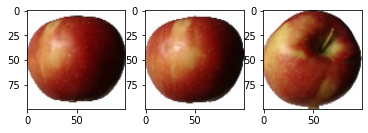

CLASS 1
Banana image examples


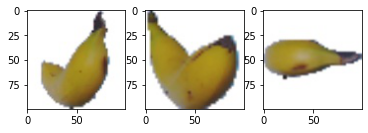

In [335]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

apple_train_link = "https://drive.google.com/drive/folders/1j-M596K7252N40ntYQOCMVjpASLFco9M?usp=share_link"
banana_train_link = "https://drive.google.com/drive/folders/1jZvNwVZDPN6Q52nY6cu9hj_p3jOeomVt?usp=share_link"

!git clone https://github.com/alexjbusch/fruit_classification_from_scratch

banana_path = "/content/fruit_classification_from_scratch/banana_train"

apple_path = "/content/fruit_classification_from_scratch/apple_train"

bananas = os.listdir(banana_path)
apples = os.listdir(apple_path)

print("\n")

path = apple_path+ "/"+apples[0]
print("CLASS 0")
print("Apple image examples:")
image = np.asarray(Image.open(path))
plt.subplot(1,3,1)
plt.imshow(image)

path = apple_path+ "/"+apples[100]
image = np.asarray(Image.open(path))
plt.subplot(1,3,2)
plt.imshow(image)

path = apple_path+ "/"+apples[300]
image = np.asarray(Image.open(path))
plt.subplot(1,3,3)
plt.imshow(image)
plt.show()

print("CLASS 1")
path = banana_path+ "/"+ bananas[0]
print("Banana image examples")
image = np.asarray(Image.open(path))
plt.subplot(1,3,1)
plt.imshow(image)

path = banana_path+ "/"+ bananas[100]
plt.subplot(1,3,2)
image = np.asarray(Image.open(path))
plt.imshow(image)

path = banana_path+ "/"+ bananas[120]
plt.subplot(1,3,3)
image = np.asarray(Image.open(path))
plt.imshow(image)
plt.show()

def show_image(class_label,index):
  if class_label == 1:
    path = banana_path + "/"+ bananas[index]
  elif class_label == 0:
    path = apple_path + "/"+ apples[index]
  image = np.asarray(Image.open(path))
  plt.imshow(image)
  plt.show()

For a simple classification task, I decided to use images of fruit from this dataset, called Fruits 360: https://www.kaggle.com/datasets/moltean/fruits

The above six images are examples from the Apple Braeburn and Banana folders in the dataset.  There are 492 apples and 490 bananas, and all of them are square 100x100 images.  Although the images have color, for simplicity we will grayscale them before passing them through the neural net.

<br>

Now that we have our images, we'll randomly set aside 10% of them as a testing dataset and train on the rest.

In [336]:
import random

def generate_test_set(apple_train, banana_train):
  print(f"Sequestering {int(len(bananas)/10)*2} pictures for testing")
  test_samples = random.sample(apples,int(len(bananas)/10))
  apple_test_indicies = [apples.index(sample) for sample in test_samples]

  test_samples = random.sample(bananas,int(len(apples)/10))
  banana_test_indicies = [bananas.index(sample) for sample in test_samples]

  return apple_test_indicies, banana_test_indicies




apple_test, banana_test = generate_test_set(apples,bananas)

nn = NeuralNetwork(10000)

print("[Apple class: apple guess, Banana class: banana guess")

def train():
    image_pair = ["",""]
    image_class = 0
    image_index = 0
    while image_index < len(bananas):

        if image_index in apple_test:
          image_class = 1
          #print("in apple")
        elif image_index in banana_test:
          image_class = 0
          image_index += 1
          continue
          #print("in banana")
        elif image_index in apple_test and image_index in banana_test:
          image_index += 1
          #print("in both")
          continue


        if image_class == 0:

            image_path = apple_path + "/"+apples[image_index]

            image = np.asarray(Image.open(image_path).convert('L'))
            input_vector = image.flatten()


        elif image_class == 1:

            image_path = banana_path + "/"+bananas[image_index]
            image = np.asarray(Image.open(image_path).convert('L'))
            input_vector = image.flatten()
            
            image_index += 1
        
        
        input_vector = np.array(input_vector)

        output_vectors = nn.forward(input_vector)
        output_vectors.insert(0,input_vector)

                             
        prediction = output_vectors[-1]

        error = L2_loss(image_class, prediction)

        nn.backpropagate(output_vectors, image_class)

        prediction = nn.forward(input_vector)[-1]
        error = L2_loss(image_class, prediction)



        
        if image_index % 300 == 0:
            if image_class ==0:
                image_pair[0] = str(image_class) + " : "+ str(prediction[0])
            elif image_class == 1:
                image_pair[1] = str(image_class) + " : "+ str(prediction[0])
            if image_pair[0] and image_pair[1]:
                print(image_pair)
                image_pair = ["",""]

        if image_class == 1:
          image_class = 0
        elif image_class == 0:
          image_class = 1
                
epochs = 10
for epoch in range(epochs):
    train()

Sequestering 98 pictures for testing
[Apple class: apple guess, Banana class: banana guess


<ipython-input-333-2a998eaf377d>:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


['0 : 0.6857854842340634', '1 : 0.7360188579029986']
['0 : 0.01375763024552306', '1 : 0.7622140779806112']
['0 : 0.005387942536129833', '1 : 0.7843106346240919']
['0 : 0.0030977610513754535', '1 : 0.8007851129713525']
['0 : 0.0020900585943445468', '1 : 0.8135184778542681']
['0 : 0.001541120309295966', '1 : 0.8237533361202344']
['0 : 0.001203184507614878', '1 : 0.8322235963878937']
['0 : 0.0009777614272982404', '1 : 0.8393869231411691']
['0 : 0.0008185331286306812', '1 : 0.8455468972788835']
['0 : 0.0007011039902541462', '1 : 0.8509152207176829']


The above output shows a guess for the same apple/banana pair once per epoch (which trains on every image in the dataset).  The class code for apple is 1.  The class code for banana is 0.  

<br>

Unsurprisingly, the results aren't great with one hidden layer of three neurons after 10 epochs.  Let's see how it does on the testing data.

In [337]:
!pip install pretty-confusion-matrix

import numpy as np
from pretty_confusion_matrix import pp_matrix_from_data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-333-2a998eaf377d>:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


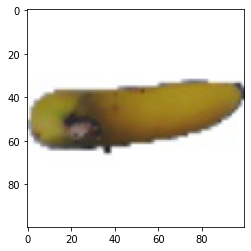

Correct class: 1, prediction: 0.9866637625904632


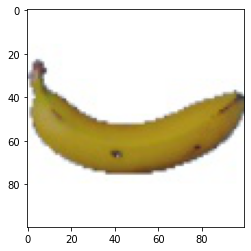

Correct class: 1, prediction: 0.9866637625904632


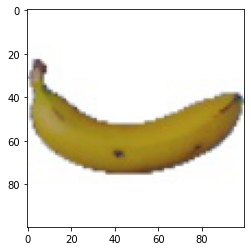

Correct class: 1, prediction: 0.9866637625904632


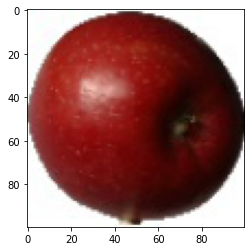

Correct class: 0, prediction: 3.981134679474438e-05


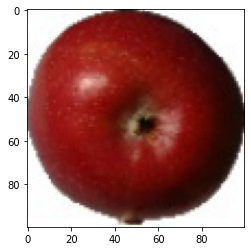

Correct class: 0, prediction: 3.981134679474438e-05


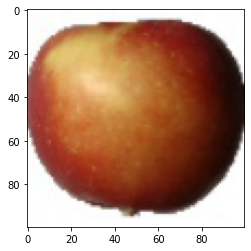

Correct class: 0, prediction: 0.033720911826267394


/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

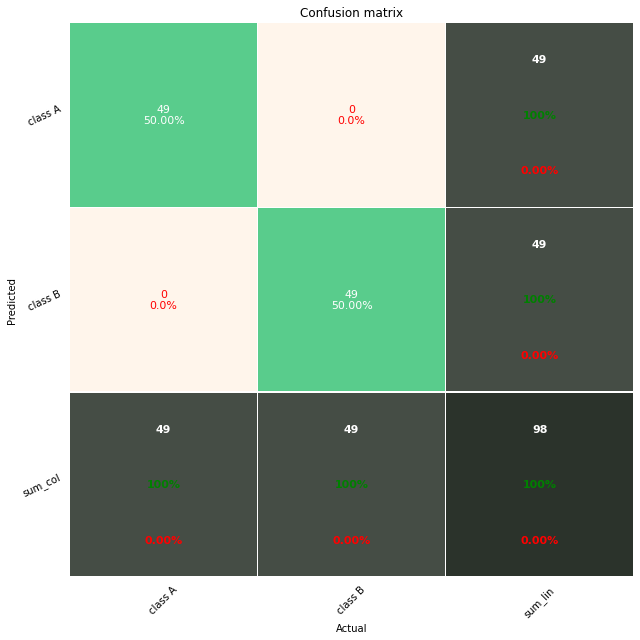

In [338]:
def test(verbose = True):
  apple_predictions = []
  banana_predictions = []

  false_positives = 0
  false_negatives = 0
  true_positives = 0
  true_negatives = 0

  iteration = 0
  for image_index in banana_test:
    image_path = banana_path + "/"+bananas[image_index]
    image = np.asarray(Image.open(image_path).convert('L'))
    input_vector = image.flatten()            
    input_vector = np.array(input_vector)
    output_vectors = nn.forward(input_vector)  
    prediction = output_vectors[-1][0]                         
    iteration += 1

    if prediction > 0.5:
      true_positives += 1
      banana_predictions.append(1)
    else:
      false_negatives += 1
      banana_predictions.append(0)

    if iteration < 4:
      if verbose:
        show_image(1,image_index)
        print(f"Correct class: {1}, prediction: {output_vectors[-1][0]}")



  iteration = 0
  for image_index in apple_test:
      iteration += 1
      image_path = apple_path + "/"+apples[image_index]
      image = np.asarray(Image.open(image_path).convert('L'))
      input_vector = image.flatten()
      input_vector = np.array(input_vector)
      output_vectors = nn.forward(input_vector)  
      prediction = output_vectors[-1][0]                           

      if prediction > 0.5:
        apple_predictions.append(1)
        false_positives += 1
      else:
        true_negatives += 1
        apple_predictions.append(0)

      if iteration < 4:
        if verbose:
          show_image(0,image_index)
          print(f"Correct class: {0}, prediction: {output_vectors[-1][0]}")

  if verbose:
    y_test = [1 for i in range(len(apple_test))] + [0 for i in range(len(banana_test))]
    y_test = np.array(y_test)

    predic = []
    for i in banana_predictions:
      predic.append(i)
    for i in apple_predictions:
      predic.append(i)
    predic = np.array(predic)
    pp_matrix_from_data(y_test, predic)

  elif not verbose:
    return banana_predictions, apple_predictions

test()

The above results show 3 example predictions from each class, as well as a confusion matrix.  The confusion matrix shows true and false positives in the top row and false and true negatives on the bottom row. (Class A is apples, class B is bananas).  The accuracy (% correct / total samples) is shown as the green number in the bottom right square.


Most of the time this will have a pretty high false positive or false negative rate, which shows that solving an image recongnition problem like this would take a lot more than 10 epochs with our current neural network, and might never converge to a good accuracy.  

<br>

So how do we make it better?  Let's try adding more hidden layer neurons to allow it to recognize more complicated patterns:

(Be patient, it'll take longer to train with 24 neurons)

In [339]:
nn = NeuralNetwork(10000, num_hidden_layer_neurons=24)
epochs = 10
for epoch in range(epochs):
    train()

<ipython-input-333-2a998eaf377d>:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


['0 : 0.14252297993229324', '1 : 0.8538517967309939']
['0 : 0.05420639018119522', '1 : 0.9058127941053945']
['0 : 0.03932112732206836', '1 : 0.6456247905489407']
['0 : 0.03272425183653688', '1 : 0.6043052995507142']
['0 : 0.029056700239931104', '1 : 0.587716617667971']
['0 : 0.02631606749444276', '1 : 0.5803535927221032']
['0 : 0.02407231629927887', '1 : 0.5774708570112234']
['0 : 0.022204302808827275', '1 : 0.5772189405123404']
['0 : 0.020653102291246797', '1 : 0.578630564025099']
['0 : 0.019363675644009128', '1 : 0.5810957571789153']


<ipython-input-333-2a998eaf377d>:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


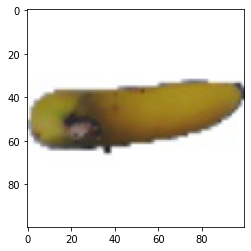

Correct class: 1, prediction: 0.9997123402146794


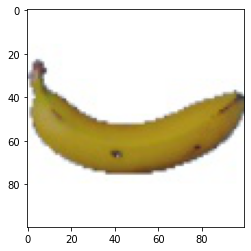

Correct class: 1, prediction: 0.9997123402146794


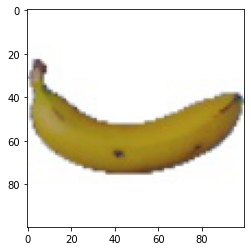

Correct class: 1, prediction: 0.8799368901389061


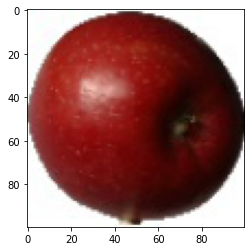

Correct class: 0, prediction: 0.046708079704958064


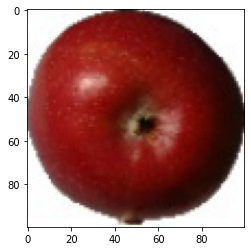

Correct class: 0, prediction: 0.046708079704958064


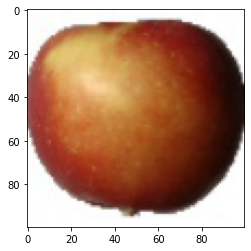

Correct class: 0, prediction: 0.8799368901389061


/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

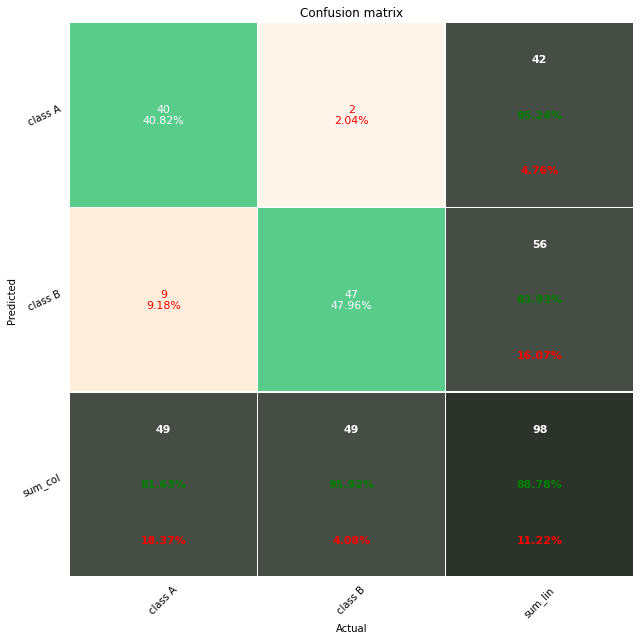

In [340]:
test()

Is the accuracy better than it was with 3 neurons?  Due to the random sampling of a small dataset and only ten epochs, the 24 neuron net may have performed better or worse when you ran it just now.  But if its performance randomly fluctuates, how do we know if 24 hidden layer neurons actually made it better?

<br>

The answer is k-fold cross validation.  We run it k times, each time taking a different random sampling to be the testing data, and compare the results at the end.  Do to the law of large numbers, the higher k is, the closer the reported performance we see will be to the actual performance.  This lets us comare the two nets.

10-fold cross validation is standard but that took about 10 minutes to run, so let's do 3-fold instead.  You can always feel free to change the k value to 10 if you have the patience.

In [341]:
def cross_validate(apple_predictions,banana_predictions):
    y_test = [1 for i in range(len(apple_predictions))] + [0 for i in range(len(banana_predictions))]
    y_test = np.array(y_test)

    predic = []
    for i in banana_predictions:
      predic.append(i)
    for i in apple_predictions:
      predic.append(i)
    predic = np.array(predic)
    pp_matrix_from_data(y_test, predic)

TRAINING THE 3 NEURON NET
Sequestering 98 pictures for testing
K-fold number: 0


<ipython-input-333-2a998eaf377d>:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


['0 : 0.2762928373456612', '1 : 0.6044776153245577']
['0 : 0.47740772857276703', '1 : 0.6044776237234728']
['0 : 0.47740772857276703', '1 : 0.6044776237234728']
['0 : 0.47740772857276703', '1 : 0.6044776237234728']
['0 : 0.47740772857276703', '1 : 0.6044776237234728']
['0 : 0.47740772857276703', '1 : 0.6044776237234728']
['0 : 0.47740772857276703', '1 : 0.6044776237234728']
['0 : 0.47740772857276703', '1 : 0.6044776237234728']
['0 : 0.47740772857276703', '1 : 0.6044776237234728']
['0 : 0.47740772857276703', '1 : 0.6044776237234728']
Sequestering 98 pictures for testing
K-fold number: 1
['0 : 0.815990268543964', '1 : 0.8584374781780054']
['0 : 0.8356234024058159', '1 : 0.8719286742236726']
['0 : 0.4572671976022516', '1 : 0.5604090531054126']
['0 : 0.4572671976022515', '1 : 0.5604090531054123']
['0 : 0.4572671976022515', '1 : 0.5604090531054123']
['0 : 0.4572671976022515', '1 : 0.5604090531054123']
['0 : 0.4572671976022515', '1 : 0.5604090531054123']
['0 : 0.4572671976022515', '1 : 0.560

/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

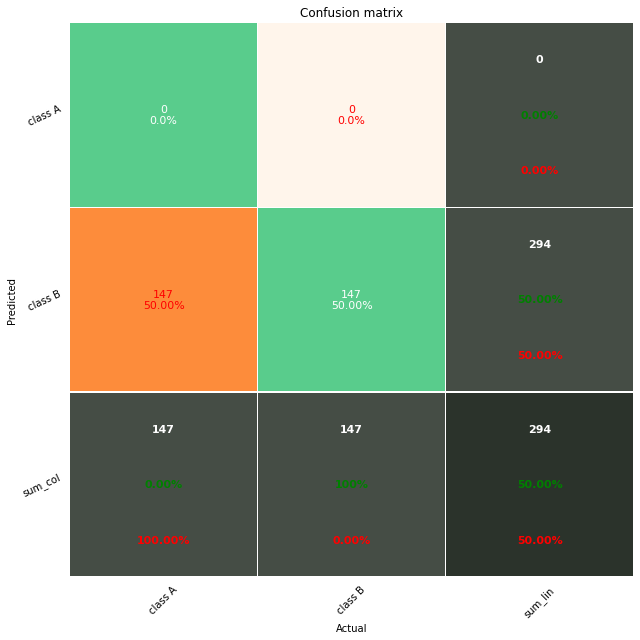

TRAINING THE 24 NEURON NET
Sequestering 98 pictures for testing
K-fold number: 0


<ipython-input-333-2a998eaf377d>:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


['0 : 0.015897638203961128', '1 : 0.8837920941939242']
['0 : 0.011181963569806642', '1 : 0.8506986245474423']
['0 : 0.008358892205922792', '1 : 0.8841616526146037']
['0 : 0.004626280901998549', '1 : 0.8353654557557689']
['0 : 0.001621403588749626', '1 : 0.8560351991927619']
['0 : 0.001197085558016726', '1 : 0.8725066164282475']
['0 : 0.0009474414291950404', '1 : 0.8843599405994722']
['0 : 0.0007793522986266006', '1 : 0.8931660480163833']
['0 : 0.0006580810976505387', '1 : 0.9000003316606398']
['0 : 0.0005664552394261073', '1 : 0.9055209108597871']
Sequestering 98 pictures for testing
K-fold number: 1
Sequestering 98 pictures for testing
K-fold number: 2
['0 : 0.03027309126318473', '1 : 0.29857577310293576']
['0 : 0.06841985170222789', '1 : 0.3178553467505955']
['0 : 0.054211402529509976', '1 : 0.3954166037414903']
['0 : 0.03919767116292961', '1 : 0.37646990037938793']
['0 : 0.03182126485163686', '1 : 0.3689475394829905']
['0 : 0.027238829349346887', '1 : 0.3655423921787539']
['0 : 0.02

/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

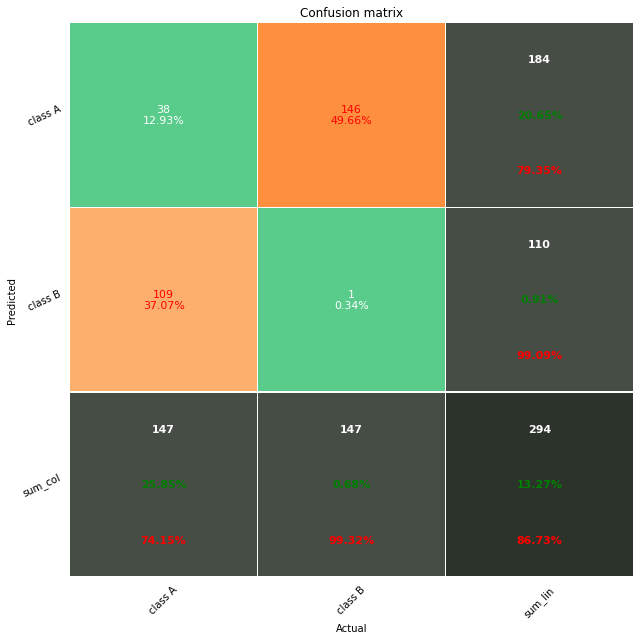

In [342]:
# change this number to 10 for 10-fold cross validation
k = 3
epochs = 10


apple_predictions = []
banana_predictions = []
print("TRAINING THE 3 NEURON NET")
for i in range(k):
  apple_test, banana_test = generate_test_set(apples,bananas)
  nn = NeuralNetwork(10000, num_hidden_layer_neurons=3)
  print(f"K-fold number: {i}")
  for epoch in range(epochs):
    train()
  ap, bp = test(verbose=False)
  apple_predictions += ap
  banana_predictions += bp

print(f"3 HIDDEN LAYER NEURONS {k} FOLD CROSS VALIDATION")
cross_validate(apple_predictions,banana_predictions)

print("TRAINING THE 24 NEURON NET")
apple_predictions = []
banana_predictions = []
for i in range(k):
  apple_test, banana_test = generate_test_set(apples,bananas)
  nn = NeuralNetwork(10000, num_hidden_layer_neurons=24)
  print(f"K-fold number: {i}")
  for epoch in range(epochs):
    train()
  ap, bp = test(verbose=False)
  apple_predictions += ap
  banana_predictions += bp

print(f"24 HIDDEN LAYER NEURONS {k} FOLD CROSS VALIDATION")
cross_validate(apple_predictions,banana_predictions)


Comparing the two, you'll see that the 24 neuron network actually did *worse* than the 3 neuron network.  This might be surprising, but it demonstrates that image recognition is much more complicated than something like the XOR problem, and can't be solved with a single layer vanilla neural network like this one.  The reason is that we only have one hidden layer.  Deep neural networks take a lot longer to train, but having multiple layers allows them to solve much more complicated problems.  Furthermore, Convolutional Neural Networks (CNNs) use edge detecting kernals and other tricks to filter out the pixels that aren't as important.

Stay tuned for a tutorial on deep learning and CNNs from scratch!